In [2]:
import pandas as pd
import numpy as np
from os import listdir
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy import stats as st
from sklearn.preprocessing import scale

In [434]:
M_ = 20 # days to review
L_ = 10 #days to predict
M = np.linspace(1,M_,M_).astype('int')
L = np.linspace(1,L_,L_).astype('int')

In [6]:
def DMD(data, r):
    ## Build data matrices
    X1 = data[:, : -1]
    X2 = data[:, 1 :]
    ## Perform singular value decomposition on X1
    u, s, v = np.linalg.svd(X1, full_matrices = False)
    ## Compute the Koopman matrix
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    ## Perform eigenvalue decomposition on A_tilde
    Phi, Q = np.linalg.eig(A_tilde)
    ## Compute the coefficient matrix
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ Q
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)
    
    return A_tilde, Phi, A

In [7]:
def DMD4cast(data, r, pred_step):
    N, T = data.shape
    _, _, A = DMD(data, r)
    mat = np.append(data, np.zeros((N, pred_step)), axis = 1)
    for s in range(pred_step):
        mat[:, T + s] = (A @ mat[:, T + s - 1]).real
    return mat[:, - pred_step :]

In [8]:
def finder(X,accu=0.95):
    _, s, _ = np.linalg.svd(X, full_matrices = False)
    if np.sum(s)==0:
        return 0
    for i in np.arange(0,s.shape[0]):
        energy = np.sum(s[:i])/np.sum(s)
        if energy>accu:
            return i

In [9]:
def oldest(data):
    years = []
    for i in range(len(data)):
        year = np.array(data[i]["Date"].iloc[0].split(sep = "-")).astype('int')
        years.append(year)
    return years

In [10]:
def loader(cat_root):
    companies = listdir(cat_root)
    dat = []
    for i in companies:
        
        a = pd.read_csv(cat_root+i)
        a1 = a.dropna()
        if a1.shape[0] != a.shape[0]:
            continue 
        a.drop(columns=['High','Low','Adjusted Close','Volume'],inplace=True)
        #a.dropna(inplace=True)
        dat.append(a)
    return dat

In [211]:
def update(dat):
    new_data = []
    old = np.array(oldest(dat))
    y = np.sort(np.unique(old[:,2]))
    if y[-1]>2022:
        
        if old[old[:,2]==y[-1]].shape[0]/old.shape[0] < 0.1:
            for i in np.where(old[:,2]==y[-1])[0]:
                dat.pop(i)
                
    old = np.array(oldest(dat))
    year = max(old[:,2])
    search = old[old[:,2]==year]
    month = max(search[:,1])
    last = old[(old[:,2]==year)&(old[:,1]==month)][0]

    
    for i in range(len(dat)):

        years = np.array([np.array(dat[i]["Date"].values[j].split(sep="-")).astype('int') for j in range(dat[i]["Date"].values.shape[0])])
        mask = np.prod(years==last,axis=1).astype('bool')
        ind = min(np.where(mask)[0])
        #dat[i].set_index('Date',inplace=True)
        new_data.append(dat[i].loc[ind:])
    return new_data

In [355]:
def smoother(dat):
    new_data = []
    for i in range(len(dat)):
      comp = dat[i].set_index('Date')
      comp['Close'] = (comp['Close'].rolling(3).mean())
      comp['Open'] = (comp['Open'].rolling(3).mean())
      comp.dropna(inplace=True, axis=0)
      new_data.append(comp)
    return new_data

In [12]:
def comp_load(dat):
    X = []
    Y = []
    for company in dat:
        comp = company['Close'].values
        comp2 = company['Open'].values
        #if comp.shape[0]*0.5 > np.sum(comp):
        #    continue   
        X.append(comp) # el primero es viejo el ultimo es el mas nuevo
        Y.append(comp2)
    r = np.array(pd.DataFrame(X).dropna())
    r2 = np.array(pd.DataFrame(Y).dropna())
    return r,r2

In [13]:
def scoring(pred,real):
    varr= (real[:,-1]-real[:,0])/real[:,0]
    varp = (pred[:,-1]-real[:,0])/real[:,0]
    upp = varp>=0
    downp =  varp<0
    upr = varr>=0
    downr =  varr<0
    score = (upp & upr)|(downp&downr)
    return np.mean(score)

In [14]:
def scoring2(pred,real):
    varr= (real[:,1:]-real[:,:-1])/real[:,:-1]
    varp = (pred[:,1:]-real[:,:-1])/real[:,:-1]
    upp = varp>=0
    downp =  varp<0
    upr = varr>=0
    downr =  varr<0
    score = (upp & upr)|(downp&downr)
    l_score = np.mean(score,axis=1)
    return np.mean(l_score,axis=0)

In [15]:
def suma(a):
    t = np.array(a)
    f = t.astype('bool')
    s = np.sum(t[f])
    if s==0:
        return None
    return s

In [34]:
def griderEMA(X,accu=0.95,seed=100, num =100):
         
        grid = np.zeros((M.shape[0],L.shape[0]))
        weights = np.ones(num)#np.arange(1,num+1)
        w2 = weights/np.sum(weights)
        for m in M:
                for l in L:
                        aux = []
                        for off in np.arange(0,num):
                                r = finder(X[:, suma([-off,-m,-seed,-l])  :  suma([-off,-l,-seed]) ], accu )
                                pred = DMD4cast(X[:, suma([-off,-m,-seed,-l,1]) : suma([-off,-l,-seed,1]) ], r ,l)
                                real = X[:, suma([-off,-l,-seed,-1]):suma([-off,-seed])]
                                aux.append(scoring(pred,real))

                        aux = np.array(aux)

                        grid[m-1,l-1] = np.sum(aux*w2)
        return grid

In [218]:
def griderEMA2(X,accu=0.95,seed=100, num =100):
        
        grid = np.zeros((M.shape[0],L.shape[0]))
        weights = np.ones(num)#np.arange(1,num+1)
        w2 = weights/np.sum(weights) 
        for m in M:
                for l in L:
                        aux = []
                        for off in np.arange(0,num):
                                r = finder(X[:, (-off-m-seed-l)  :  -off-l-seed ], accu )
                                pred = DMD4cast(X[:, (-off-m-seed-l) : (-off-l-seed) ], r ,l)
                                real = X[:, (-off-l-seed):(-off-seed)]
                                aux.append(scoring2(pred,real))
                        aux = np.array(aux)
                        grid[m-1,l-1] = np.sum(aux*w2)
        return grid

## Train ALL

In [16]:
data_path = '../stock-market-scraper-master/historic_data/'
categories = listdir(data_path)
grids = []

In [209]:
num = M_ * 2
seed = 1
true_cat = []
for cat in categories:
    try:
        root = data_path + cat +'/'
        data_pre = loader(root)
        data = update(data_pre)
        X = comp_load(data)
        grid = griderEMA2(X,0.95,seed,num)
        grids.append(grid)
        true_cat.append(cat)
    except:
        print(cat)
        continue

In [210]:
conv_grids = []
points_max = []
shape = (3,3)  
for grid in grids:
    kernel = np.full(shape,1/(shape[0]*shape[1]))
    grad = signal.convolve2d(grid, kernel, boundary='symm', mode='same')
    conv_grids.append(grad)
    x , y = np.where(grad==np.max(grad))
    points_max.append((x,y))


In [184]:
np.save('grids_v2.npy',grids)
np.save('pointsmax.npy',points_max)

In [211]:
%matplotlib qt5
Nc = 4
Nr = 40//4
fig, axs = plt.subplots(Nr, Nc,figsize=(30,30 ),facecolor='lightskyblue',layout='constrained')
fig.set_facecolor('0.85')
fig.suptitle('Categories')

images = []
ind = 0
for i in range(Nr):
    for j in range(Nc):
        # Generate data with a range that varies from one plot to the next.
        ind = i*Nc + j
        if len(grids)<ind+1:
            break
        cut= np.histogram(grad.ravel())[1][-2]
        data = (conv_grids[ind]>cut)*1.0 + (conv_grids[ind]==np.max(conv_grids[ind]))*1.0
        images.append(axs[i, j].imshow(data))
        axs[i, j].set_title(true_cat[ind]+' '+str(np.round(cut,2)),loc='left')
        axs[i, j].label_outer()

In [212]:
categ

['Apparel Stores',
 'Application Software',
 'Asset Management',
 'Credit Services',
 'Drug Manufacturers - Major',
 'Electric Utilities',
 'Foreign Regional Banks',
 'Gold',
 'Internet Information Providers',
 'Money Center Banks',
 'Multimedia & Graphics Software',
 'Personal Products',
 'REIT - Diversified',
 'Telecom Services - Domestic']

## Train Single

In [493]:
#root = 'Electric/'
root = "../stock-market-scraper-master/historic_data/Electric Utilities/"
data_pre = loader(root) 
data_true = update(data_pre)
data_smooth = smoother(data_true)
X,Y = comp_load(data_smooth)
data_true = [ data_true[i].set_index('Date') for i in range(len(data_true))]
X_t , Y_t = comp_load(data_true)
X.shape

(33, 259)

<Axes: xlabel='Date'>

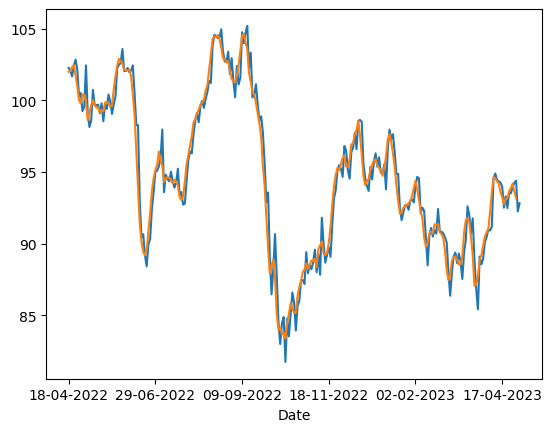

In [494]:
data_true[1].Close.plot()
data_smooth[1].Close.plot()

In [514]:
num = 100
seed = 8
grid = griderEMA(X,0.95,seed,num)
#grid2 = griderEMA(Y,0.95,seed,num)

## Convoluciono el mapeo del grid para encontrar cuantos dias atras tengo que investigar
(la idea es buscar puntos calientes en el grid, es decir, cluster de buenas predicciones)

0.7731885521885522

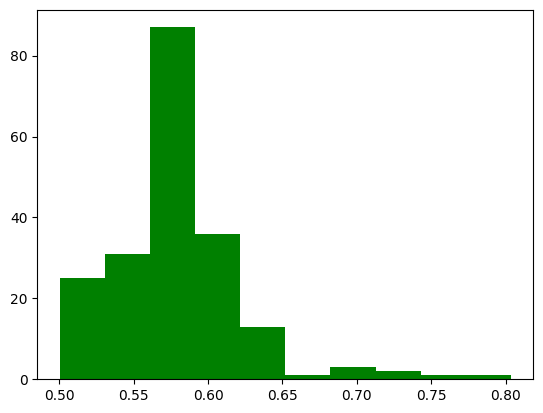

In [515]:
shape = (3,3)
kernel = np.full(shape,1/(shape[0]*shape[1]))
grad = signal.convolve2d(grid2, kernel, boundary='symm', mode='same')
x , y = np.where(grad==np.max(grad))
h = np.histogram(grad.ravel(),10)
pylab.hist(grad.ravel(),h[1], color='g')
cut = h[1][-2]
cut

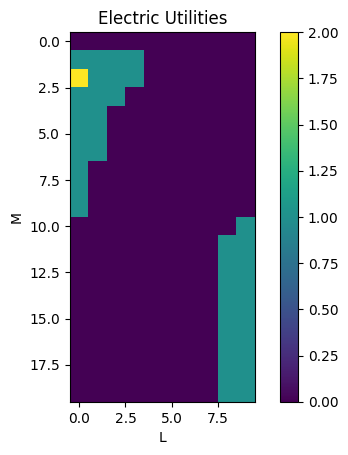

In [516]:
view = (grad>0.6)*1.0 + (grad==np.max(grad))*1.0
plt.imshow(view)
plt.ylabel('M')
plt.xlabel('L')
plt.title(root.split(sep="/")[-2])
plt.colorbar()

In [517]:
if (np.max(grad)>0.53) & (cut>0.53):
    if grad[x[0],y[0]] == np.max(grad):
        m = x[0]+1
        l = y[0]+1
        print(m,l)
else:
    print('No se compra')
if np.abs(m-l)>1:
    if m>l:
        print(m,l)
        print('ok')
    else:
        print('No se compra')

3 1
3 1
ok


## Test

In [456]:
m = 18
l = 11

In [428]:
cat = "Apparel Stores"
cate = np.array(categ)
m,l = p[np.where(cate==cat)[0][0]]
print(m,l)
root = "../stock-market-scraper-master/historic_data/" + cat + "/"
data_pre = loader(root)
data = update(data_pre)
X = comp_load(data) 

NameError: name 'categ' is not defined

In [537]:
data_true[0][2:]

,Open,Close
Date,,
18-04-2022,96.559998,96.080002
19-04-2022,96.540001,96.620003
20-04-2022,97.519997,98.510002
21-04-2022,98.489998,97.809998
22-04-2022,97.690002,96.879997
...,...,...
21-04-2023,90.239998,89.959999
24-04-2023,90.089996,90.720001
25-04-2023,90.760002,90.760002


In [542]:
off = seed+1

In [547]:
test = X[:,suma([-m,-off]):suma([-off])]#+1
proof = X_t[:,suma([-off,-1]):suma([-off,l])]
#finder(test,0.95)
t = DMD4cast(test, finder(test,0.95) ,l)
prediction = ((t[:,-1]-proof[:,0])/proof[:,0] )
pred = prediction>0.0
if np.sum(pred) < X.shape[0]*0.1:
    if np.sum(pred) == 0:
        print('No hay')
    print('Hay pocos')

In [520]:
reality = (proof[:,-1]-proof[:,0])/proof[:,0]
real = reality>0

In [521]:
accu = np.sum(real&pred)*100/np.sum(pred)
print('predijo correctamente el {0:.3}%'.format(accu))

predijo correctamente el 84.2%


In [522]:
stocks = np.sum(pred)
interest = np.sum((reality)[pred])/stocks
print('Inverti la misma cantidad de plata en {0} acciones y gane un {1:.3}%'.format(stocks,interest*100))

Inverti la misma cantidad de plata en 19 acciones y gane un 0.506%


In [523]:
weight = (prediction)[pred]/np.sum((prediction)[pred])
interest = np.sum((weight*(reality[pred])))
print('Inverti la cantidad de plata proporcional a la prediccion en {0} acciones y gane un {1:.3}%'.format(stocks,interest*100))

Inverti la cantidad de plata proporcional a la prediccion en 19 acciones y gane un 0.486%


In [524]:
pred2 = (prediction) ==  np.max(prediction)
interest = reality[pred2][0]
print('Inverti toda la plata en la accion que mas predigo que crece y gane un {0:.3}%'.format(interest*100))

Inverti toda la plata en la accion que mas predigo que crece y gane un 1.17%


## BLob Detector

In [17]:
def pointer(grad,cut):
    x , y = np.where(grad==np.max(grad))
    if (np.max(grad)>0.54) & (cut>0.54):
            return x[0],y[0]
    else:
        return 0,0

In [18]:
def nigh(grid,m,l):

    near = grid[m+1,l]*1 + grid[m,l+1]*1 + grid[m-1,l]*1 + grid[m,l-1]*1
    if near<4:
        return False
        
    return True    
    

In [19]:
def floodfill(surface,x, y):
    oldColor=1 
    newColor=0
    weight = 0
    # assume surface is a 2D image and surface[x][y] is the color at x, y.
    theStack = [ (x, y) ]
    flag= nigh(surface,x,y)
    while len(theStack) > 0:

        x, y = theStack.pop()

        if surface[x][y] != oldColor:

            continue

        surface[x][y] = newColor
        weight+=1
        
        if x+1 < surface.shape[0]:
            theStack.append( (x + 1, y) )  # right
        
            theStack.append( (x - 1, y) )  # left
        
        if y+1 < surface.shape[1]:
            theStack.append( (x, y + 1) )  # down
        
        theStack.append( (x, y - 1) )  # up
    if np.sum(surface)==0:
        return False
        
    ratio = weight/np.sum(surface)
    if ratio<0.8:
        flag = False
        
    return flag

## Category finder

In [21]:
data_path = '../stock-market-scraper-master/historic_data/'
categories = listdir(data_path)
shape = (3,3)
kernel = np.full(shape,1/(shape[0]*shape[1]))

def scavenger(categories,seed,num):
    true_cat = []
    max_points = []
    for cat in categories:
        try: 
            root = data_path + cat +'/'
            data_pre = loader(root)
            data = update(data_pre)
            X , _  = comp_load(data)
            grid = griderEMA(X,0.95,seed,num)
        except:
            print('There was an exception in '+ cat+' for seed '+ str(seed))
            continue
        grad = signal.convolve2d(grid, kernel, boundary='symm', mode='same')
        cut = np.histogram(grad.ravel())[1][-2]
        surface = grad>cut

        m,l = pointer(grad,cut)
        if (m>=M_-1) | (l>=L_-1):
            continue
        if (m<=1) | (l<=1):
            continue
        if m/l < 0.6:
            continue

        if floodfill(surface,m,l):
            true_cat.append(cat)
            m = m + 1
            l = l + 1
            max_points.append((m,l))
    return true_cat,max_points


## Relative Strength 

In [ ]:
def relative_strength_idx(dat, n=14):
    rsi = []
    for i in range(dat):
        close = dat[i]['Close']
        delta = close.diff()
        delta = delta[1:]
        pricesUp = delta.copy()
        pricesDown = delta.copy()
        pricesUp[pricesUp < 0] = 0
        pricesDown[pricesDown > 0] = 0
        rollUp = pricesUp.rolling(n).mean()
        rollDown = pricesDown.abs().rolling(n).mean()
        rs = rollUp / rollDown
        rsi.append(100.0 - (100.0 / (1.0 + rs)))
    return rsi

In [22]:
categ , p = scavenger(categories,20,5)
categ

['Apparel Stores', 'Money Center Banks', 'Multimedia & Graphics Software']

In [25]:
result, aux = tester(categ,p,20)
print(result,aux)

Hay pocos Apparel Stores
Hay pocos Multimedia & Graphics Software
0.049567121688467004 [-0.012398897665549129, 0.09699768099387511, 0.06410258173707503]


In [24]:
def tester(categ,p,seed):
    aux = []
    categ = np.array(categ)
    for cat in categ:
        
        m,l = p[np.where(categ==cat)[0][0]]
        root = data_path + cat +'/'
        data_pre = loader(root)
        data = update(data_pre)
        X, _ = comp_load(data)

        test = X[:,suma([-m,-seed]):suma([-seed])]#+1
        proof = X[:,suma([-seed,-1]):suma([-seed,l])]
        f = finder(test,0.95)
        if f == 0:
            print('Problems in finder '+ cat)
            continue
        t = DMD4cast(test, finder(test,0.95) ,l)
        prediction = ((t[:,-1]-proof[:,0])/proof[:,0] )
        pred = prediction>0.05
        comp = np.sum(pred)
        if comp < 2:
            print('Hay pocos '+ cat)
            #continue
        reality = (proof[:,-1]-proof[:,0])/proof[:,0]

        interest = np.sum(reality[ prediction ==  np.max(prediction) ])
        aux.append(interest)
    return np.sum(aux)/len(aux) ,aux

In [29]:
pronter = []
cat_store = []
data_path = '../stock-market-scraper-master/historic_data/'
categories = listdir(data_path)
num = M_ * 2
for i in np.arange(L_,L_+30)[::-1]:
    seed = i
    categ , p = scavenger(categories,seed,num)
    result , aux = tester(categ,p,seed)
    print(i)
    pronter.append(result)


Hay pocos Apparel Stores
Hay pocos Personal Products
Hay pocos Telecom Services - Domestic
49
Hay pocos Apparel Stores
Hay pocos Personal Products
Hay pocos Semiconductor - Broad Line
48
Hay pocos Agricultural Chemicals
Hay pocos Apparel Stores
Hay pocos Personal Products
47
Hay pocos Agricultural Chemicals
Hay pocos Asset Management
Hay pocos Gold
Hay pocos Money Center Banks
Hay pocos Personal Products
46
Hay pocos Agricultural Chemicals
Hay pocos Asset Management
Hay pocos Gold
Hay pocos Money Center Banks
Hay pocos Personal Products
Hay pocos Semiconductor - Broad Line
45
Hay pocos Agricultural Chemicals
Hay pocos Asset Management
Hay pocos Money Center Banks
Hay pocos Personal Products
44
Hay pocos Apparel Stores
Hay pocos Specialty Retail, Other
43
Hay pocos Apparel Stores
Hay pocos Specialty Retail, Other
42
Hay pocos Apparel Stores
Hay pocos Independent Oil & Gas
41
Hay pocos Apparel Stores
40
Hay pocos Agricultural Chemicals
Hay pocos Apparel Stores
Hay pocos Networking & Comm

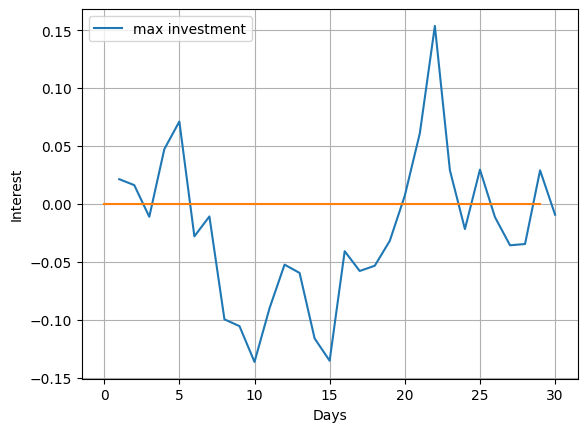

In [31]:
pronter = np.array(pronter)
days = np.arange(1,pronter.shape[0]+1)
#plt.plot(days,pronter[:,1],label='equal investment')
#plt.plot(days,pronter[:,2],label='weighted investment')
plt.plot(days,pronter,label='max investment')
plt.plot(np.zeros((pronter.shape[0])))
plt.ylabel('Interest')
plt.xlabel('Days')
plt.grid(which='both')
plt.legend()

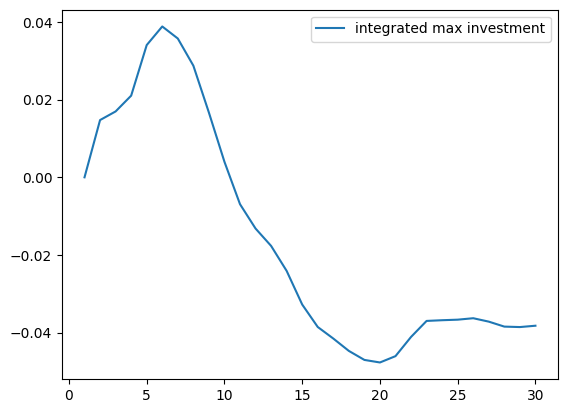

In [32]:
from scipy import integrate
#x = np.linspace(-2, 2, num=20)
x = days
pront = np.array(pronter)
#y_int = integrate.cumtrapz(pronter[:,1]/x, days, initial=0)
#y_wei = integrate.cumtrapz(pronter[:,2]/x, days, initial=0)
y_max = integrate.cumtrapz(pronter/x, days, initial=0)
#plt.plot(x, y_int,label='integrated equal investment')
#plt.plot(x, y_wei,label='integrated weighted investment')
plt.plot(x, y_max,label='integrated max investment')
plt.legend()
plt.show()